# Convolutional Neural Network to Detect Thorax Diseases from Multi-View Chest X-Rays

## Using GPU

In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
!nvidia-smi

Thu Jul  4 03:56:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.72       Driver Version: 410.72       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                  N/A |
| N/A   37C    P0    23W /  75W |     10MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P4            Off  | 00000000:00:05.0 Off |                  N/A |
| N/A   37C    P0    23W /  75W |     10MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [110]:
#  learn.destroy() ## this Learner object self-destroyed - it still exists, but no longer usable
torch.cuda.empty_cache()

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks import *
import warnings
warnings.filterwarnings('ignore')
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Looking at Data

In [2]:
path = Path('/home/maram_m_monshi/data')
train_csv = pd.read_csv(path/'train.csv')
valid_csv = pd.read_csv(path/'valid.csv')

In [5]:
path.ls()

[PosixPath('/home/maram_m_monshi/data/train'),
 PosixPath('/home/maram_m_monshi/data/train_p13'),
 PosixPath('/home/maram_m_monshi/data/valid'),
 PosixPath('/home/maram_m_monshi/data/train_p13.tar'),
 PosixPath('/home/maram_m_monshi/data/valid.csv'),
 PosixPath('/home/maram_m_monshi/data/train_p10'),
 PosixPath('/home/maram_m_monshi/data/train_p12'),
 PosixPath('/home/maram_m_monshi/data/models'),
 PosixPath('/home/maram_m_monshi/data/train.csv'),
 PosixPath('/home/maram_m_monshi/data/mimic-cxr')]

In [3]:
train_csv['Patient_Id'] = [Path(s).parents[0].parent.name for s in train_csv.path]
valid_csv['Patient_Id'] = [Path(s).parents[0].parent.name for s in valid_csv.path]

In [6]:
train_csv.shape, valid_csv.shape

((37739, 16), (2732, 16))

In [7]:
df = pd.read_csv(path/'train.csv')
df.head()

,path,view,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Airspace Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,train/p11000011/s01/view1_frontal.jpg,frontal,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,train/p11000183/s01/view1_frontal.jpg,frontal,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0
2,train/p11000183/s02/view1_frontal.jpg,frontal,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,train/p11000183/s03/view1_frontal.jpg,frontal,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,-1.0,NaN,1.0,NaN,NaN,NaN
4,train/p11000183/s03/view2_frontal.jpg,frontal,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,-1.0,NaN,1.0,NaN,NaN,NaN


In [8]:
train_csv.path[:3]

0    train/p11000011/s01/view1_frontal.jpg
1    train/p11000183/s01/view1_frontal.jpg
2    train/p11000183/s02/view1_frontal.jpg
Name: path, dtype: object

In [9]:
np.sum(train_csv['No Finding']) / len(train_csv)

0.3705980550624023

## Pre-Processing Data

In [4]:
tfms = get_transforms(True, False, max_rotate=None, max_zoom=0., max_lighting=0.3,
                      max_warp=0, p_affine=0.5, p_lighting=0.5, xtra_tfms=[])
bs = 64; size = 224;
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.4285714285714286)}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

## Evaluation (metrix for 2 classes)

In [5]:
from sklearn.metrics import roc_auc_score

class AUC(Callback):
    "AUC score"
    def __init__(self):
        pass
    
    def on_epoch_begin(self, **kwargs): 
        self.outputs = []
        self.targets = []

    def on_batch_end(self, last_output, last_target, **kwargs):
        "expects binary output with data.c=2 "
        self.outputs += list(to_np(last_output)[:, 1])
        self.targets += list(to_np(last_target))

    def on_epoch_end(self, last_metrics, **kwargs): 
        return {'last_metrics': last_metrics + [roc_auc_score(self.targets, self.outputs)]}
auc = AUC()

# Enlarged_Cardiomediastinum

In [6]:
enlarged_cardiomediastinum = 'Enlarged Cardiomediastinum'
train_enlarged_cardiomediastinum_csv = train_csv[['path', enlarged_cardiomediastinum]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_enlarged_cardiomediastinum_csv = train_enlarged_cardiomediastinum_csv[train_enlarged_cardiomediastinum_csv[enlarged_cardiomediastinum] != -1].reset_index(drop=True)
train_enlarged_cardiomediastinum_csv[enlarged_cardiomediastinum] = train_enlarged_cardiomediastinum_csv[enlarged_cardiomediastinum].astype(int)
print(enlarged_cardiomediastinum)
print(train_enlarged_cardiomediastinum_csv['Enlarged Cardiomediastinum'].value_counts(dropna=False))
train_enlarged_cardiomediastinum_csv[enlarged_cardiomediastinum].value_counts(True)

Enlarged Cardiomediastinum
0    35367
1     1019
Name: Enlarged Cardiomediastinum, dtype: int64


0    0.971995
1    0.028005
Name: Enlarged Cardiomediastinum, dtype: float64

In [7]:
itemlist = ImageList.from_df(df=train_enlarged_cardiomediastinum_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (36386 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 3056, 2544)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (32748 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3638 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (32748 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3638 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [8]:
data.classes

[0, 1]

Enlarged Cardiomediastinum


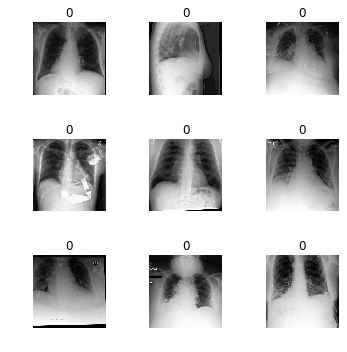

In [9]:
print(enlarged_cardiomediastinum)
data.show_batch(rows=3, figsize=(5,5))

In [10]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [11]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.128508,0.150525,0.967290,0.670742,15:43
1,0.120378,0.135784,0.968114,0.694103,15:10
2,0.127079,0.132877,0.968114,0.700085,15:12


In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07
Min loss divided by 10: 5.25E-04


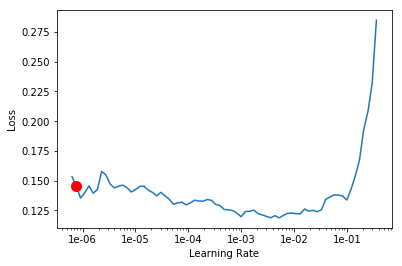

In [13]:
learn.recorder.plot(suggestion=True)

In [14]:
learn.save('enlarged_cardiomediastinum-stage-1')

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

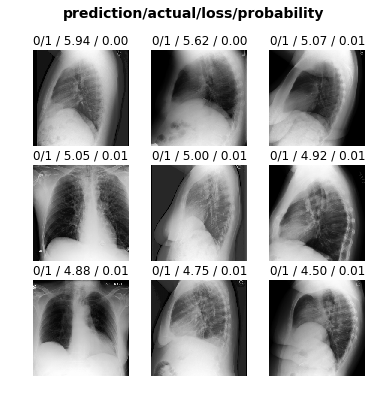

In [16]:
interp.plot_top_losses(9, figsize=(6,6))

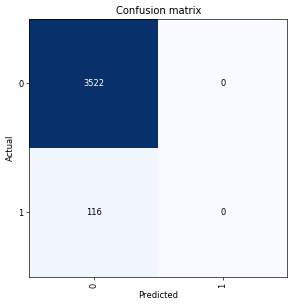

In [17]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [18]:
interp.most_confused(min_val=2)

[(1, 0, 116)]

In [19]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.130828,0.133636,0.968114,0.544408,15:17


In [20]:
learn.load('enlarged_cardiomediastinum-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (32748 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: /home/maram_m_monshi/data;

Valid: LabelList (3638 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: /home/maram_m_monshi/data;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.58E-07


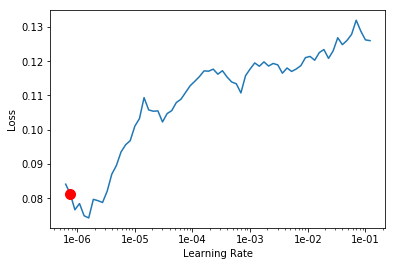

In [22]:
learn.recorder.plot(suggestion=True)

In [23]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.120552,0.131674,0.968114,0.702368,15:08
1,0.108892,0.130863,0.968114,0.705634,15:08
2,0.108792,0.131762,0.968114,0.708793,15:19
3,0.102076,0.131603,0.968114,0.710468,15:08


In [24]:
learn.save('enlarged_cardiomediastinum-stage-3')

# Cardiomegaly

In [26]:
# create clean csv drop NAs
cardiomegaly = 'Cardiomegaly'
train_cardiomegaly_csv = train_csv[['path', cardiomegaly]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_cardiomegaly_csv = train_cardiomegaly_csv[train_cardiomegaly_csv[cardiomegaly] != -1].reset_index(drop=True)
train_cardiomegaly_csv[cardiomegaly] = train_cardiomegaly_csv[cardiomegaly].astype(int)
print(cardiomegaly)
print(train_cardiomegaly_csv['Cardiomegaly'].value_counts(dropna=False))
train_cardiomegaly_csv[cardiomegaly].value_counts(True)

Cardiomegaly
0    29951
1     6932
Name: Cardiomegaly, dtype: int64


0    0.812054
1    0.187946
Name: Cardiomegaly, dtype: float64

In [27]:
itemlist = ImageList.from_df(df=train_cardiomegaly_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (36883 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 3056, 2544)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (33195 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3688 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,1,1,1,0
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (33195 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3688 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [28]:
data.classes

[0, 1]

Cardiomegaly


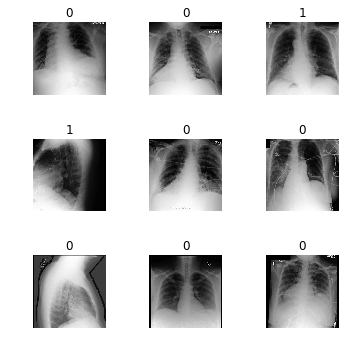

In [29]:
print(cardiomegaly)
data.show_batch(rows=3, figsize=(5,5))

In [30]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [31]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.446594,0.459129,0.796095,0.725591,13:32
1,0.422869,0.434295,0.800163,0.733750,12:54
2,0.416406,0.425925,0.803688,0.747883,13:01


In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-06


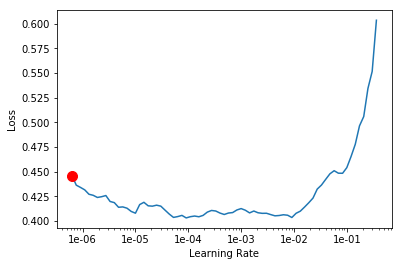

In [33]:
learn.recorder.plot(suggestion=True)

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

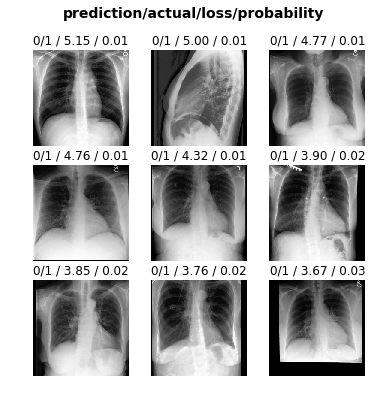

In [35]:
interp.plot_top_losses(9, figsize=(6,6))

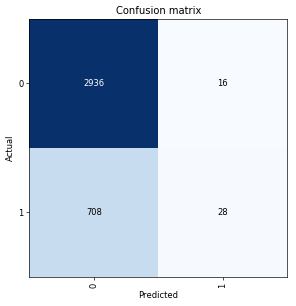

In [36]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [37]:
learn.unfreeze() 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.406583,0.411675,0.803688,0.785197,13:05


In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-06
Min loss divided by 10: 6.31E-08


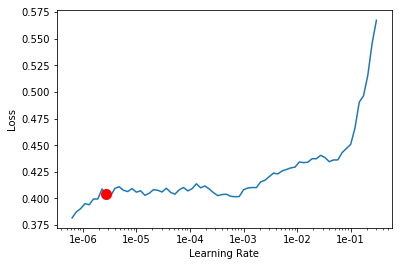

In [39]:
learn.recorder.plot(suggestion=True)

In [40]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.396444,0.403862,0.803416,0.793840,13:07
1,0.377472,0.401865,0.807213,0.799820,13:08
2,0.376652,0.399407,0.804501,0.802542,13:07
3,0.386608,0.400497,0.806399,0.802333,13:06


In [41]:
learn.save('cardiomegaly-stage-3')

# Airspace Opacity

In [43]:
# create clean csv drop NAs
airspace_opacity = 'Airspace Opacity'
train_airspace_opacity_csv = train_csv[['path', airspace_opacity]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_airspace_opacity_csv = train_airspace_opacity_csv[train_airspace_opacity_csv[airspace_opacity] != -1].reset_index(drop=True)
train_airspace_opacity_csv[airspace_opacity] = train_airspace_opacity_csv[airspace_opacity].astype(int)
print(airspace_opacity)
print(train_airspace_opacity_csv['Airspace Opacity'].value_counts(dropna=False))
train_airspace_opacity_csv[airspace_opacity].value_counts(True)

Airspace Opacity
0    29542
1     7582
Name: Airspace Opacity, dtype: int64


0    0.795766
1    0.204234
Name: Airspace Opacity, dtype: float64

In [44]:
itemlist = ImageList.from_df(df=train_airspace_opacity_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (37124 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 3056, 2544)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (33412 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,1,1,1,1
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3712 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 1,0,0,0,1
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (33412 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,1,1,1,1
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3712 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [45]:
data.classes

[0, 1]

Airspace Opacity


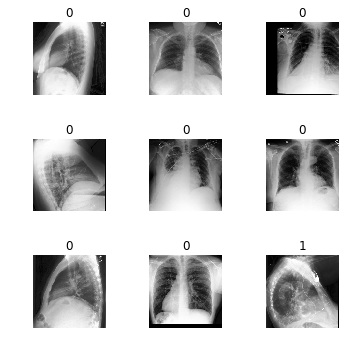

In [46]:
print(airspace_opacity)
data.show_batch(rows=3, figsize=(5,5))

In [47]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [48]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.502956,0.496579,0.783675,0.621103,14:00
1,0.470277,0.466840,0.785022,0.687345,13:54
2,0.461438,0.464369,0.785291,0.694385,13:57


In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.02E-04


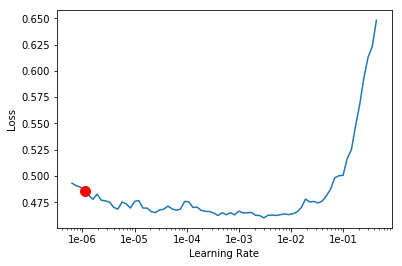

In [50]:
learn.recorder.plot(suggestion=True)

In [51]:
learn.save('airspace_opacity-stage-1')

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

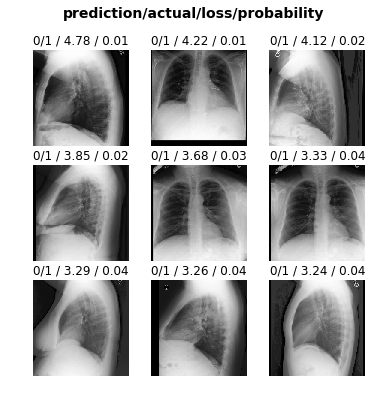

In [53]:
interp.plot_top_losses(9, figsize=(6,6))

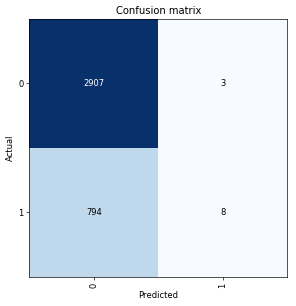

In [54]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [55]:
interp.most_confused(min_val=2)

[(1, 0, 794), (0, 1, 3)]

In [61]:
learn.unfreeze() 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.456560,0.461029,0.785291,0.712811,14:05


In [62]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-06
Min loss divided by 10: 1.32E-07


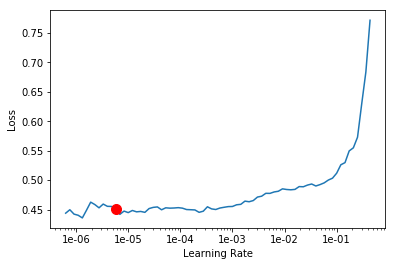

In [63]:
learn.recorder.plot(suggestion=True)

In [64]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.456777,0.457483,0.786369,0.730052,13:56
1,0.450925,0.455173,0.786907,0.730725,13:55
2,0.445789,0.454151,0.786638,0.733585,13:48
3,0.449692,0.454133,0.787446,0.737166,13:48


In [65]:
learn.save('airspace_opacity-stage-3')

# Lung Lesion

In [67]:
# create clean csv drop NAs
lung_lesion = 'Lung Lesion'
train_lung_lesion_csv = train_csv[['path', lung_lesion]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_lung_lesion_csv = train_lung_lesion_csv[train_lung_lesion_csv[lung_lesion] != -1].reset_index(drop=True)
train_lung_lesion_csv[lung_lesion] = train_lung_lesion_csv[lung_lesion].astype(int)
print(lung_lesion)
print(train_lung_lesion_csv['Lung Lesion'].value_counts(dropna=False))
train_lung_lesion_csv[lung_lesion].value_counts(True)

Lung Lesion
0    36472
1     1060
Name: Lung Lesion, dtype: int64


0    0.971757
1    0.028243
Name: Lung Lesion, dtype: float64

In [68]:
itemlist = ImageList.from_df(df=train_lung_lesion_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (37532 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 3056, 2544)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (33779 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3753 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (33779 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3753 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [69]:
data.classes

[0, 1]

Lung Lesion


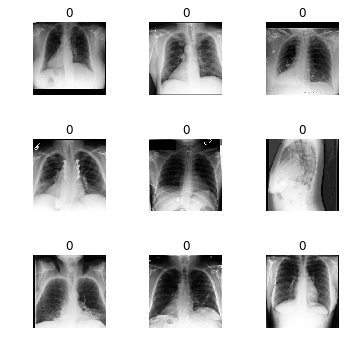

In [70]:
print(lung_lesion)
data.show_batch(rows=3, figsize=(5,5))

In [71]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [72]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.137638,0.131711,0.972555,0.520966,13:59
1,0.129711,0.122944,0.972555,0.638487,13:47
2,0.132032,0.120542,0.972555,0.612337,13:51


In [73]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.58E-03


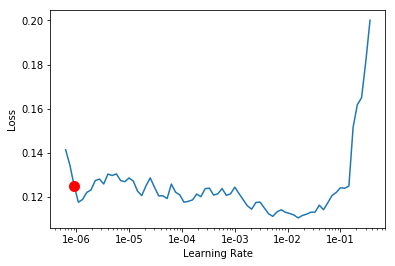

In [74]:
learn.recorder.plot(suggestion=True)

In [75]:
learn.save('lung-lesion-stage-1')

In [76]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

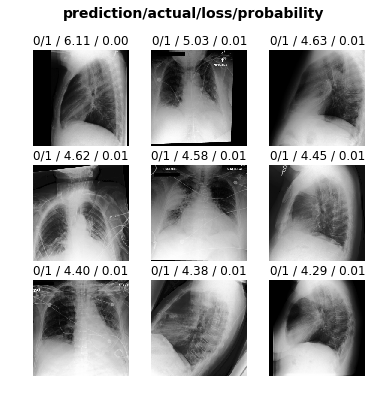

In [77]:
interp.plot_top_losses(9, figsize=(6,6))

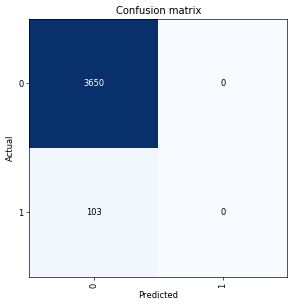

In [78]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [79]:
interp.most_confused(min_val=2)

[(1, 0, 103)]

In [80]:
learn.unfreeze() 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.132399,0.120202,0.972555,0.638213,13:56


In [81]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


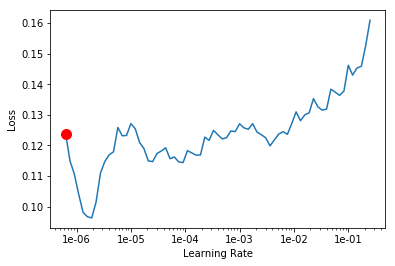

In [82]:
learn.recorder.plot(suggestion=True)

In [83]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.134034,0.119528,0.972555,0.651786,14:02
1,0.131846,0.115917,0.972555,0.688913,13:57
2,0.131201,0.113709,0.972555,0.730520,14:02
3,0.123636,0.113564,0.972555,0.729945,13:59


In [84]:
learn.save('lung-lesion-stage-3')

# Edema

In [86]:
# create clean csv drop NAs
edema = 'Edema'
train_edema_csv = train_csv[['path', edema]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_edema_csv = train_edema_csv[train_edema_csv[edema] != -1].reset_index(drop=True)
train_edema_csv[edema] = train_edema_csv[edema].astype(int)
print(edema)
print(train_edema_csv['Edema'].value_counts(dropna=False))
train_edema_csv[edema].value_counts(True)

Edema
0    31859
1     3964
Name: Edema, dtype: int64


0    0.889345
1    0.110655
Name: Edema, dtype: float64

In [87]:
itemlist = ImageList.from_df(df=train_edema_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (35823 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 3056, 2544)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (32241 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,1,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3582 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (32241 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,1,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3582 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [88]:
data.classes

[0, 1]

Edema


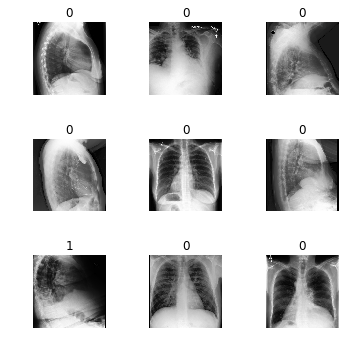

In [89]:
print(edema)
data.show_batch(rows=3, figsize=(5,5))

In [90]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [91]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.309648,0.287274,0.871022,0.816877,13:24
1,0.261225,0.248245,0.897822,0.848673,13:22
2,0.245999,0.243671,0.896147,0.857030,13:18


In [92]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-05


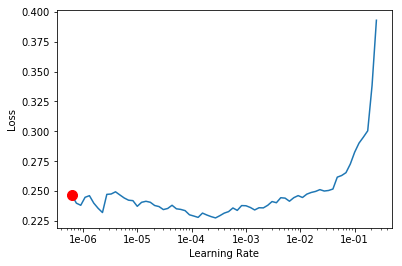

In [93]:
learn.recorder.plot(suggestion=True)

In [94]:
learn.save('edema-stage-1')

In [95]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

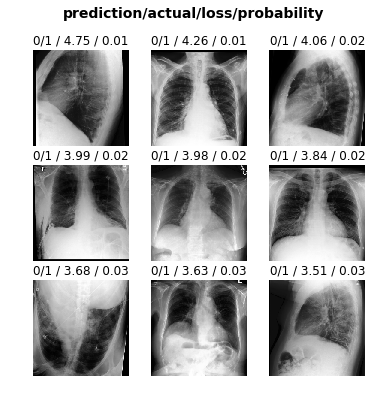

In [96]:
interp.plot_top_losses(9, figsize=(6,6))

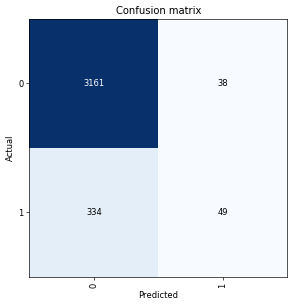

In [97]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [98]:
interp.most_confused(min_val=2)

[(1, 0, 334), (0, 1, 38)]

In [99]:
learn.unfreeze() 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.254542,0.231821,0.900614,0.887904,13:25


In [100]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


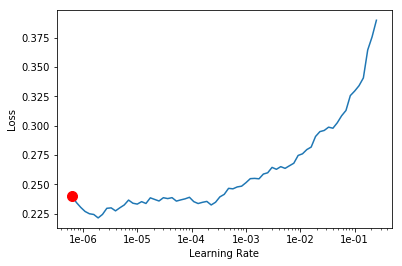

In [101]:
learn.recorder.plot(suggestion=True)

In [102]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.248622,0.226917,0.901173,0.892354,13:24
1,0.230550,0.224685,0.902010,0.894106,13:27
2,0.236094,0.220067,0.906477,0.896635,13:25
3,0.218079,0.220333,0.908431,0.897470,13:21


In [103]:
learn.save('edema-stage-3')

# Consolidation

In [105]:
# create clean csv drop NAs
consolidation = 'Consolidation'
train_consolidation_csv = train_csv[['path', consolidation]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_consolidation_csv = train_consolidation_csv[train_consolidation_csv[consolidation] != -1].reset_index(drop=True)
train_consolidation_csv[consolidation] = train_consolidation_csv[consolidation].astype(int)
print(consolidation)
print(train_consolidation_csv['Consolidation'].value_counts(dropna=False))
train_consolidation_csv[consolidation].value_counts(True)

Consolidation
0    35634
1     1410
Name: Consolidation, dtype: int64


0    0.961937
1    0.038063
Name: Consolidation, dtype: float64

In [106]:
itemlist = ImageList.from_df(df=train_consolidation_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (37044 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 3056, 2544)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (33340 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,1,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3704 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (33340 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,1,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3704 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [107]:
data.classes

[0, 1]

Consolidation


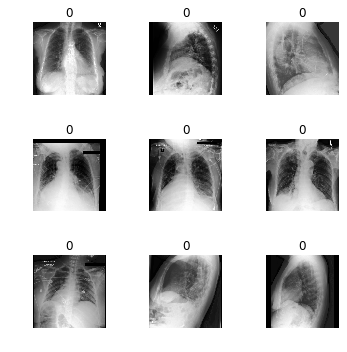

In [108]:
print(consolidation)
data.show_batch(rows=3, figsize=(5,5))

In [109]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [110]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.171048,0.139476,0.964633,0.748771,13:44
1,0.166833,0.136429,0.964633,0.758998,13:50
2,0.147034,0.133996,0.964633,0.769138,13:53


In [111]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 6.31E-08


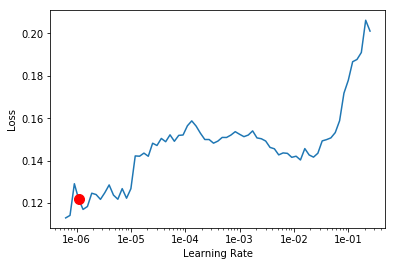

In [112]:
learn.recorder.plot(suggestion=True)

In [113]:
learn.save('consolidation-stage-1')

In [114]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

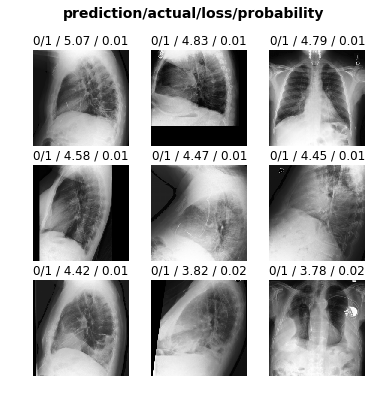

In [115]:
interp.plot_top_losses(9, figsize=(6,6))

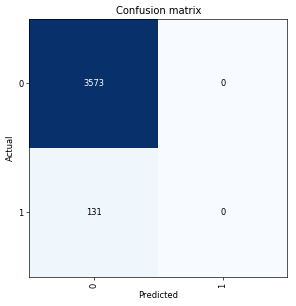

In [116]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [117]:
interp.most_confused(min_val=2)

[(1, 0, 131)]

In [118]:
learn.unfreeze() 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.150822,0.135101,0.964633,0.778122,13:59


In [119]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-07


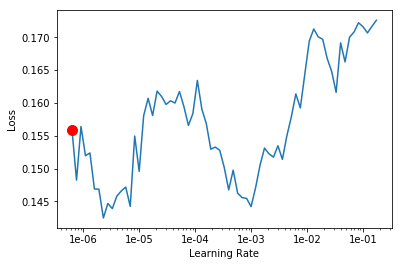

In [120]:
learn.recorder.plot(suggestion=True)

In [121]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.145480,0.133430,0.964633,0.788221,13:56
1,0.140237,0.132131,0.964633,0.797549,13:54
2,0.142119,0.131271,0.964633,0.797820,13:51
3,0.148451,0.131152,0.964633,0.799948,13:56


In [122]:
learn.save('consolidation-stage-3')

# Pneumonia

In [6]:
# create clean csv drop NAs
pneumonia = 'Pneumonia'
train_pneumonia_csv = train_csv[['path', pneumonia]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_pneumonia_csv = train_pneumonia_csv[train_pneumonia_csv[pneumonia] != -1].reset_index(drop=True)
train_pneumonia_csv[pneumonia] = train_pneumonia_csv[pneumonia].astype(int)
print(pneumonia)
print(train_pneumonia_csv['Pneumonia'].value_counts(dropna=False))
train_pneumonia_csv[pneumonia].value_counts(True)

Pneumonia
0    32202
1     2738
Name: Pneumonia, dtype: int64


0    0.921637
1    0.078363
Name: Pneumonia, dtype: float64

In [7]:
itemlist = ImageList.from_df(df=train_pneumonia_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (34940 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 3056, 2544)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (31446 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 1,1,1,0,1
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3494 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,1,0
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (31446 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 1,1,1,0,1
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3494 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [8]:
data.classes

[0, 1]

Pneumonia


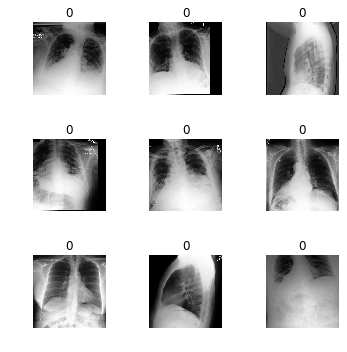

In [9]:
print(pneumonia)
data.show_batch(rows=3, figsize=(5,5))

In [10]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [11]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.311309,0.280941,0.924728,0.556275,15:42
1,0.281578,0.267612,0.924728,0.531034,15:46
2,0.270665,0.262508,0.924728,0.545431,15:51


In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.32E-07


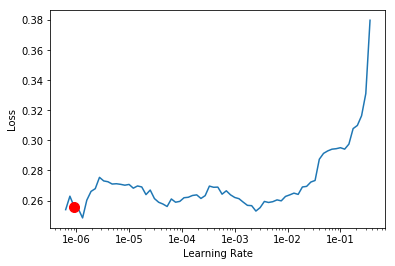

In [13]:
learn.recorder.plot(suggestion=True)

In [14]:
learn.save('pneumonia-stage-1')

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

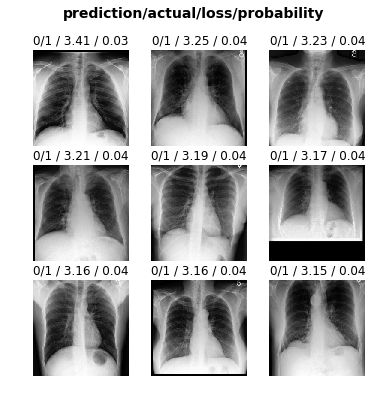

In [21]:
interp.plot_top_losses(9, figsize=(6,6))

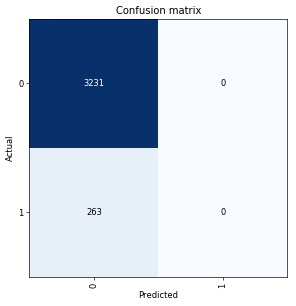

In [22]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [23]:
interp.most_confused(min_val=2)

[(1, 0, 263)]

In [24]:
learn.unfreeze() 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.275285,0.266805,0.924728,0.497622,15:42


In [25]:
learn.load('pneumonia-stage-1');
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-05
Min loss divided by 10: 9.12E-06


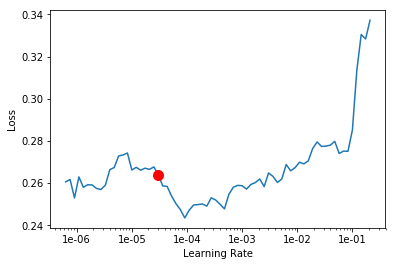

In [26]:
learn.recorder.plot(suggestion=True)

In [27]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.267650,0.262415,0.924728,0.550072,15:46
1,0.255837,0.259115,0.924728,0.585125,15:40
2,0.255176,0.260295,0.924728,0.580725,15:33
3,0.246771,0.260083,0.924728,0.587645,15:33


In [28]:
learn.save('pneumonia-stage-3')

# Atelectasis

In [30]:
# create clean csv drop NAs
atelectasis = 'Atelectasis'
train_atelectasis_csv = train_csv[['path', atelectasis]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_atelectasis_csv = train_atelectasis_csv[train_atelectasis_csv[atelectasis] != -1].reset_index(drop=True)
train_atelectasis_csv[atelectasis] = train_atelectasis_csv[atelectasis].astype(int)
print(atelectasis)
print(train_atelectasis_csv['Atelectasis'].value_counts(dropna=False))
train_atelectasis_csv[atelectasis].value_counts(True)

Atelectasis
0    29876
1     6356
Name: Atelectasis, dtype: int64


0    0.824575
1    0.175425
Name: Atelectasis, dtype: float64

In [31]:
itemlist = ImageList.from_df(df=train_atelectasis_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (36232 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 2544, 3056)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (32609 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,1,1,0,1
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3623 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,1,0,1,1
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (32609 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,1,1,0,1
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3623 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [32]:
data.classes

[0, 1]

Atelectasis


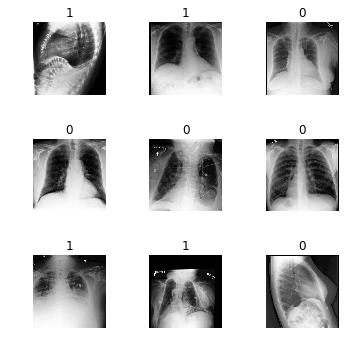

In [33]:
print(atelectasis)
data.show_batch(rows=3, figsize=(5,5))

In [34]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [35]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.453043,0.392670,0.825007,0.706044,13:56
1,0.412367,0.373321,0.835495,0.706829,13:45
2,0.399461,0.356333,0.836047,0.743950,13:45


In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-05
Min loss divided by 10: 6.31E-04


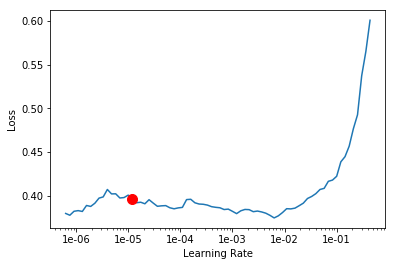

In [37]:
learn.recorder.plot(suggestion=True)

In [38]:
learn.save('atelectasis-stage-1')

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

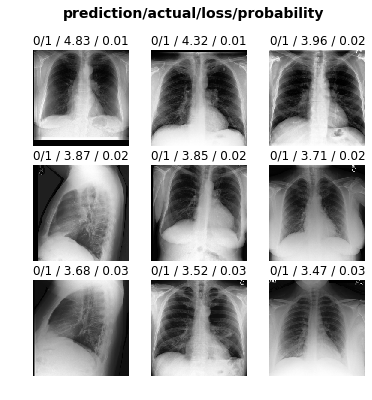

In [40]:
interp.plot_top_losses(9, figsize=(6,6))

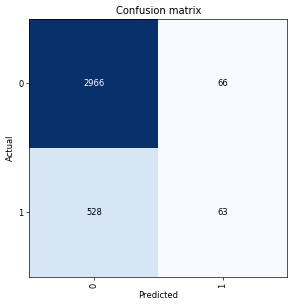

In [41]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [42]:
interp.most_confused(min_val=2)

[(1, 0, 528), (0, 1, 66)]

In [43]:
learn.unfreeze() 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.392596,0.343792,0.843500,0.827853,14:04


In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 3.98E-05


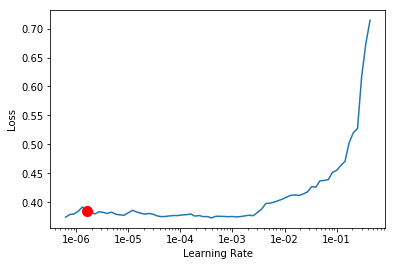

In [45]:
learn.recorder.plot(suggestion=True)

In [46]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.371848,0.339769,0.842672,0.830815,13:49
1,0.362917,0.336648,0.845708,0.835208,13:46
2,0.367167,0.334355,0.844880,0.837115,13:40
3,0.359955,0.333752,0.844880,0.838216,13:38


In [47]:
learn.save('atelectasis-stage-3')

# Pneumothorax

In [49]:
# create clean csv drop NAs
pneumothorax = 'Pneumothorax'
train_pneumothorax_csv = train_csv[['path', pneumothorax]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_pneumothorax_csv = train_pneumothorax_csv[train_pneumothorax_csv[pneumothorax] != -1].reset_index(drop=True)
train_pneumothorax_csv[pneumothorax] = train_pneumothorax_csv[pneumothorax].astype(int)
print(pneumothorax)
print(train_pneumothorax_csv['Pneumothorax'].value_counts(dropna=False))
train_pneumothorax_csv[pneumothorax].value_counts(True)

Pneumothorax
0    36059
1     1523
Name: Pneumothorax, dtype: int64


0    0.959475
1    0.040525
Name: Pneumothorax, dtype: float64

In [50]:
itemlist = ImageList.from_df(df=train_pneumothorax_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (37582 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 3056, 2544)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (33824 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3758 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (33824 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3758 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [51]:
data.classes

[0, 1]

Pneumothorax


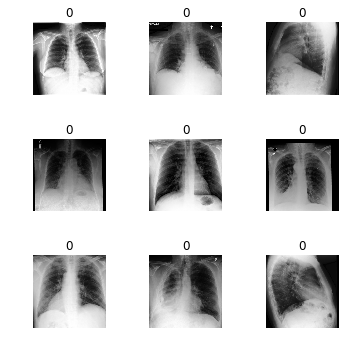

In [52]:
print(pneumothorax)
data.show_batch(rows=3, figsize=(5,5))

In [53]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [54]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.163995,0.163387,0.957956,0.710693,15:17
1,0.148116,0.145443,0.958222,0.786774,15:01
2,0.136932,0.137157,0.957956,0.817301,15:03


In [55]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-06
Min loss divided by 10: 6.31E-08


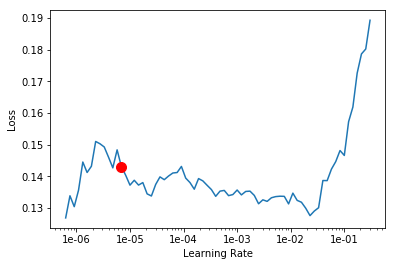

In [56]:
learn.recorder.plot(suggestion=True)

In [57]:
learn.save('pneumothorax-stage-1')

In [58]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

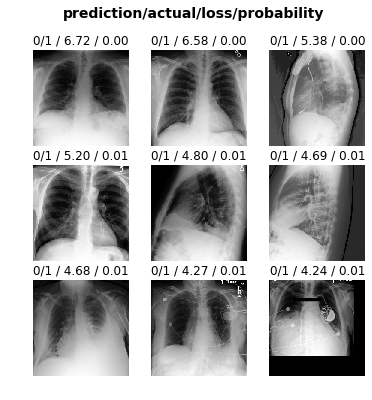

In [59]:
interp.plot_top_losses(9, figsize=(6,6))

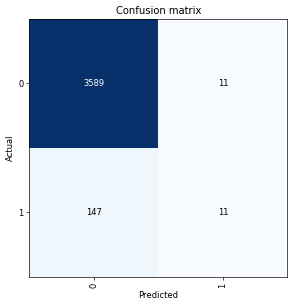

In [60]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [61]:
interp.most_confused(min_val=2)

[(1, 0, 147), (0, 1, 11)]

In [62]:
learn.unfreeze() 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.131900,0.134019,0.959021,0.839896,15:08


In [63]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07
Min loss divided by 10: 4.37E-06


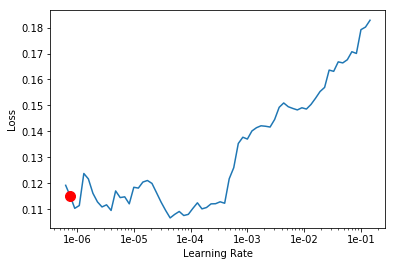

In [64]:
learn.recorder.plot(suggestion=True)

In [65]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.128304,0.129550,0.960085,0.853175,15:00
1,0.131333,0.127811,0.960883,0.862053,14:55
2,0.127608,0.127183,0.960085,0.868509,15:02
3,0.118687,0.126950,0.960351,0.860441,14:58


In [66]:
learn.save('pneumothorax-stage-3')

# Pleural Effusion

In [68]:
# create clean csv drop NAs
pleural_effusion = 'Pleural Effusion'
train_pleural_effusion_csv = train_csv[['path', pleural_effusion]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_pleural_effusion_csv = train_pleural_effusion_csv[train_pleural_effusion_csv[pleural_effusion] != -1].reset_index(drop=True)
train_pleural_effusion_csv[pleural_effusion] = train_pleural_effusion_csv[pleural_effusion].astype(int)
print(pleural_effusion)
print(train_pleural_effusion_csv['Pleural Effusion'].value_counts(dropna=False))
train_pleural_effusion_csv[pleural_effusion].value_counts(True)

Pleural Effusion
0    28994
1     7869
Name: Pleural Effusion, dtype: int64


0    0.786534
1    0.213466
Name: Pleural Effusion, dtype: float64

In [69]:
itemlist = ImageList.from_df(df=train_pleural_effusion_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (36863 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 3056, 2544)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (33177 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,1,1,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3686 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 1,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (33177 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,1,1,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3686 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [70]:
data.classes

[0, 1]

Pleural Effusion


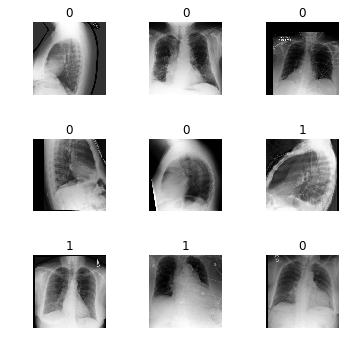

In [71]:
print(pleural_effusion)
data.show_batch(rows=3, figsize=(5,5))

In [72]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [73]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.424658,0.373678,0.828540,0.837963,14:53
1,0.362600,0.337526,0.846446,0.869601,14:51
2,0.337566,0.328089,0.846175,0.881502,14:49


In [74]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 6.31E-08


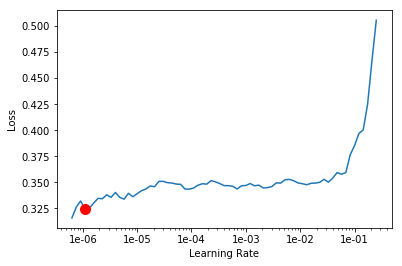

In [75]:
learn.recorder.plot(suggestion=True)

In [76]:
learn.save('pleural-effusion-stage-1')

In [77]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

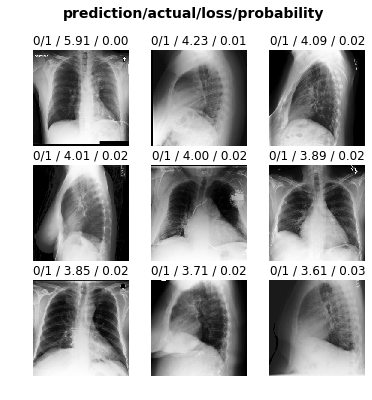

In [78]:
interp.plot_top_losses(9, figsize=(6,6))

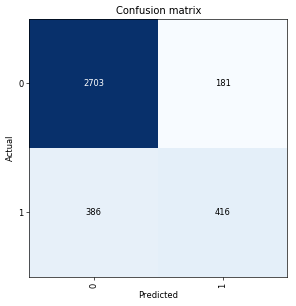

In [79]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [80]:
interp.most_confused(min_val=2)

[(1, 0, 386), (0, 1, 181)]

In [81]:
learn.unfreeze() 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.321144,0.306156,0.858383,0.891714,14:50


In [82]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 3.98E-05


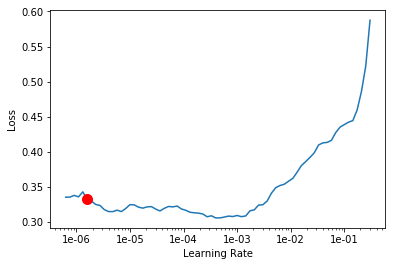

In [83]:
learn.recorder.plot(suggestion=True)

In [84]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.304562,0.295072,0.866793,0.903787,14:38
1,0.307558,0.294831,0.867336,0.906807,14:52
2,0.292944,0.287721,0.872491,0.905057,14:49
3,0.287970,0.289463,0.870863,0.899963,14:47


In [85]:
learn.save('pleural-effusion-stage-3')

# Pleural Other

In [87]:
# create clean csv drop NAs
pleural_other = 'Pleural Other'
train_pleural_other_csv = train_csv[['path', pleural_other]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_pleural_other_csv = train_pleural_other_csv[train_pleural_other_csv[pleural_other] != -1].reset_index(drop=True)
train_pleural_other_csv[pleural_other] = train_pleural_other_csv[pleural_other].astype(int)
print(pleural_other)
print(train_pleural_other_csv['Pleural Other'].value_counts(dropna=False))
train_pleural_other_csv[pleural_other].value_counts(True)

Pleural Other
0    37132
1      425
Name: Pleural Other, dtype: int64


0    0.988684
1    0.011316
Name: Pleural Other, dtype: float64

In [88]:
itemlist = ImageList.from_df(df=train_pleural_other_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (37557 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 3056, 2544)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (33802 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3755 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (33802 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3755 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [89]:
data.classes

[0, 1]

Pleural Other


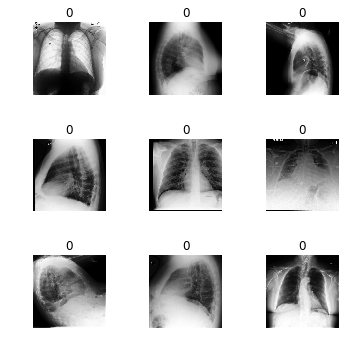

In [90]:
print(pleural_other)
data.show_batch(rows=3, figsize=(5,5))

In [91]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [92]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.073027,0.048509,0.992277,0.585883,15:17
1,0.059503,0.042433,0.992277,0.637292,15:07
2,0.063180,0.042945,0.992277,0.676597,15:01


In [93]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.92E-03


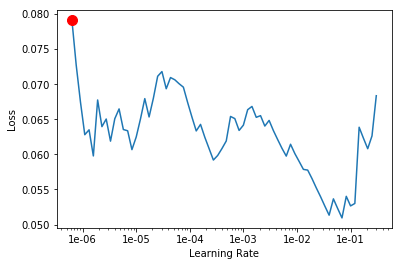

In [94]:
learn.recorder.plot(suggestion=True)

In [95]:
learn.save('pleural-other-stage-1')

In [101]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

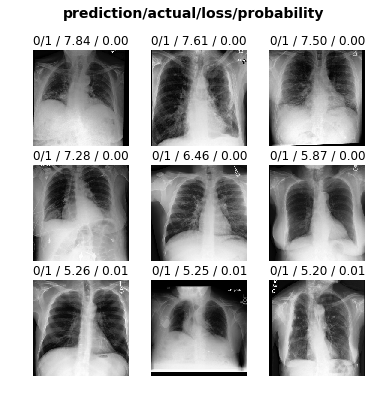

In [102]:
interp.plot_top_losses(9, figsize=(6,6))

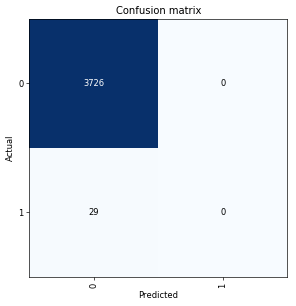

In [103]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [104]:
interp.most_confused(min_val=2)

[(1, 0, 29)]

In [105]:
learn.unfreeze() 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.063556,0.045025,0.992277,0.533446,15:14


In [106]:
learn.load('pleural-other-stage-1');
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


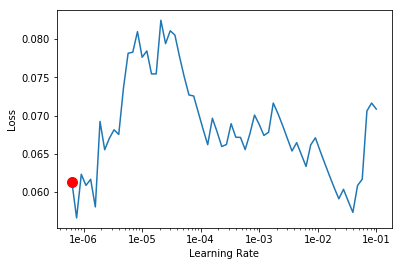

In [107]:
learn.recorder.plot(suggestion=True)

In [108]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.055975,0.042515,0.992277,0.707581,15:06
1,0.060929,0.041352,0.992277,0.736030,15:08
2,0.051030,0.042649,0.992277,0.739695,15:09
3,0.047811,0.043217,0.992011,0.727627,15:11


In [109]:
learn.save('pleural-other-stage-3')

# Fracture

In [111]:
# create clean csv drop NAs
fracture = 'Fracture'
train_fracture_csv = train_csv[['path', fracture]].fillna(0).reset_index(drop=True)
# U-ignore: ignores uncertain predictions
train_fracture_csv = train_fracture_csv[train_fracture_csv[fracture] != -1].reset_index(drop=True)
train_fracture_csv[fracture] = train_fracture_csv[fracture].astype(int)
print(fracture)
print(train_fracture_csv['Fracture'].value_counts(dropna=False))
train_fracture_csv[fracture].value_counts(True)

Fracture
0    36829
1      805
Name: Fracture, dtype: int64


0    0.97861
1    0.02139
Name: Fracture, dtype: float64

In [112]:
itemlist = ImageList.from_df(df=train_fracture_csv, path=path, folder='.', suffix='')
itemlists = itemlist.split_by_rand_pct(0.1)
data = (itemlists.label_from_df()
    .transform(tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
itemlist, itemlists, data

(ImageList (37634 items)
 Image (3, 3056, 2544),Image (3, 2544, 3056),Image (3, 2544, 3056),Image (3, 3056, 2544),Image (3, 3056, 2544)
 Path: /home/maram_m_monshi/data, LabelLists;
 
 Train: LabelList (33871 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3763 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Test: None, ImageDataBunch;
 
 Train: LabelList (33871 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 0,0,0,0,0
 Path: /home/maram_m_monshi/data;
 
 Valid: LabelList (3763 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: Cat

In [113]:
data.classes

[0, 1]

Fracture


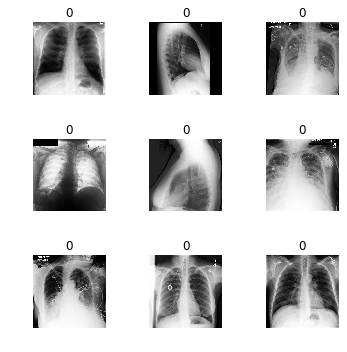

In [114]:
print(fracture)
data.show_batch(rows=3, figsize=(5,5))

In [115]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, auc])
learn.model = nn.DataParallel(learn.model)

In [116]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.113749,0.104751,0.978475,0.546323,15:14
1,0.105873,0.104121,0.978475,0.563234,15:14
2,0.096531,0.101268,0.978475,0.576143,15:12


In [117]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.29E-07


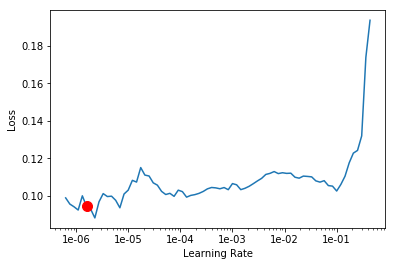

In [118]:
learn.recorder.plot(suggestion=True)

In [119]:
learn.save('fracture-stage-1')

In [120]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

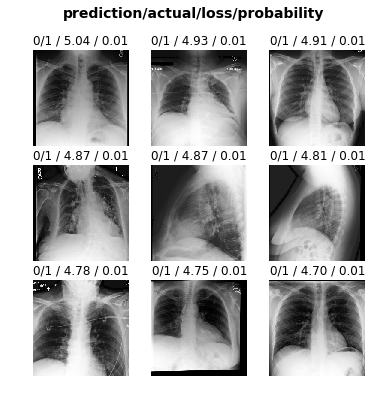

In [121]:
interp.plot_top_losses(9, figsize=(6,6))

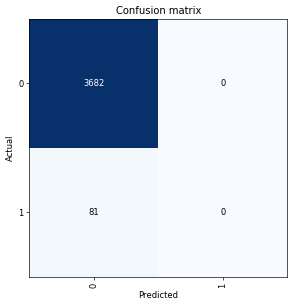

In [122]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [123]:
interp.most_confused(min_val=2)

[(1, 0, 81)]

In [124]:
learn.unfreeze() 
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.113278,0.102570,0.978475,0.606648,15:07


In [125]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-06
Min loss divided by 10: 6.31E-08


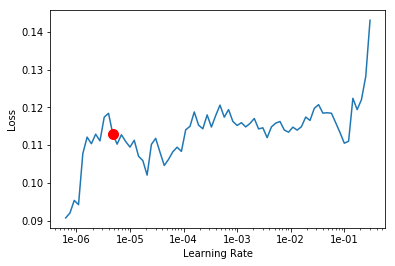

In [126]:
learn.recorder.plot(suggestion=True)